In [1]:
%pylab inline
from glob import glob
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

Populating the interactive namespace from numpy and matplotlib


Reading file names and excluding the first three files

In [2]:
Files = glob('*.txt')
Files = Files[3:]

Analysing torque curve to find stability time and other values of interest

C:\Users\Reinhard\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


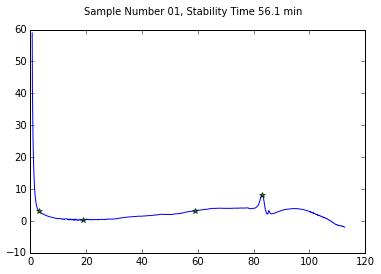

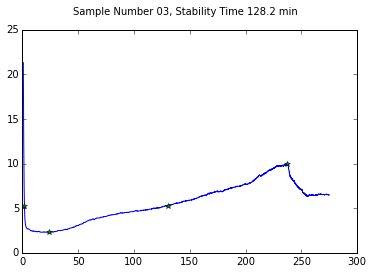

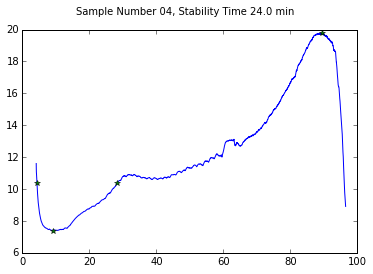

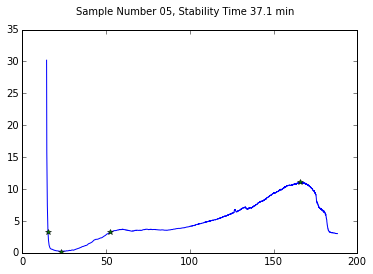

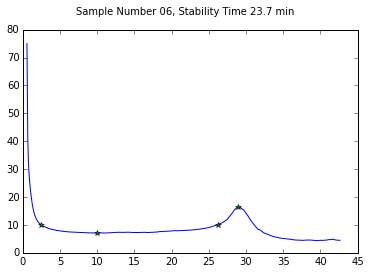

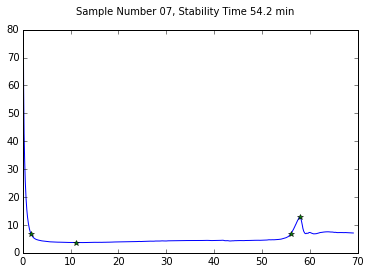

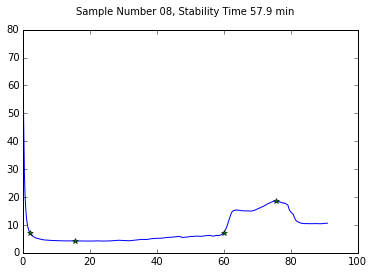

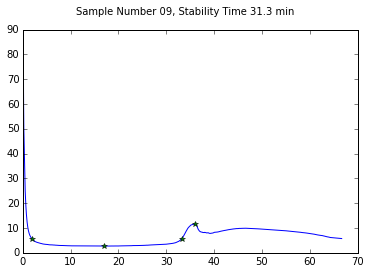

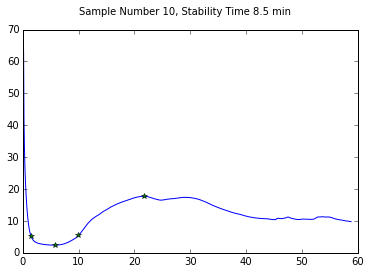

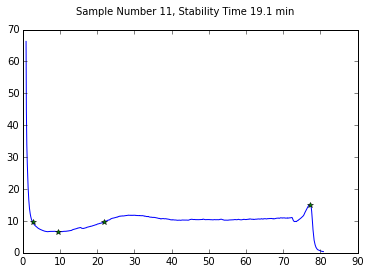

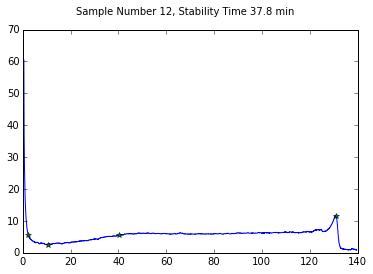

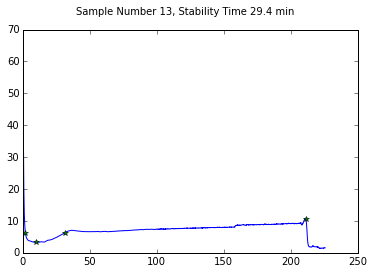

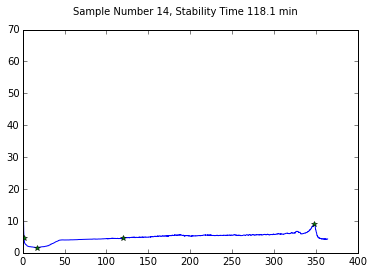

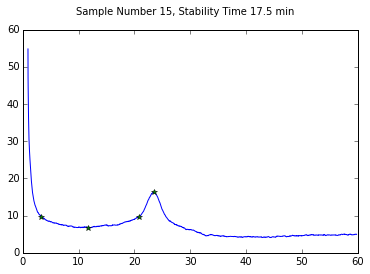

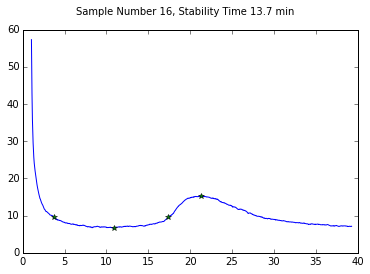

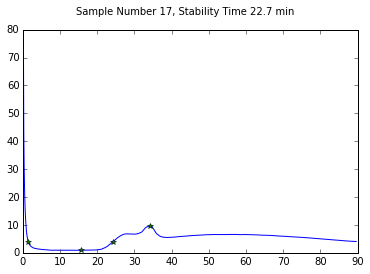

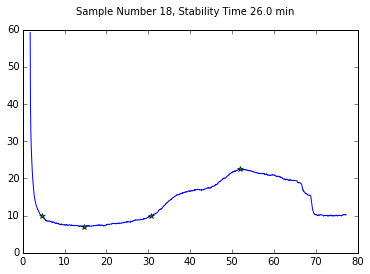

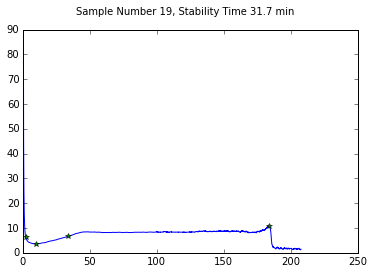

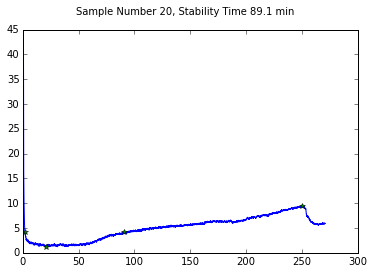

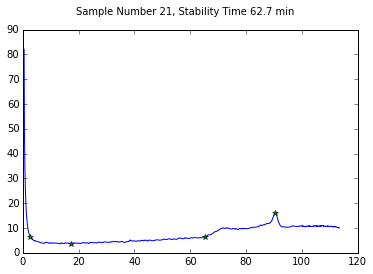

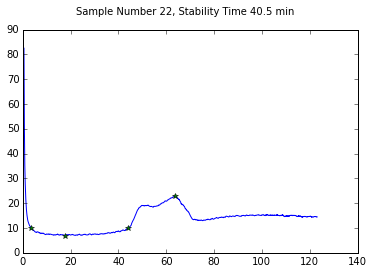

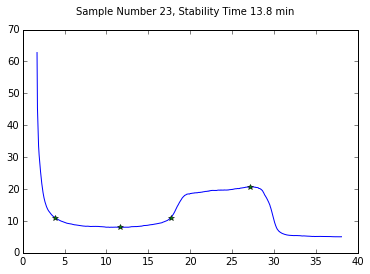

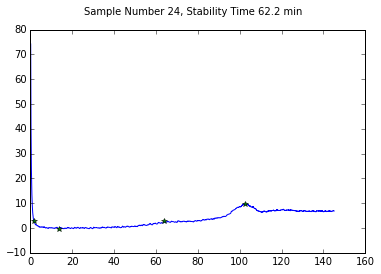

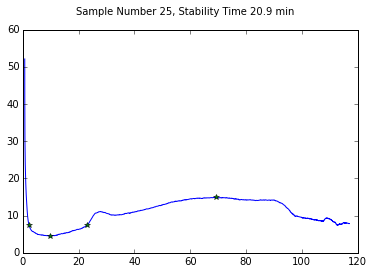

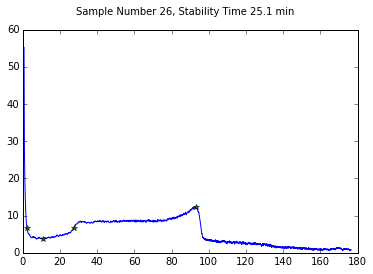

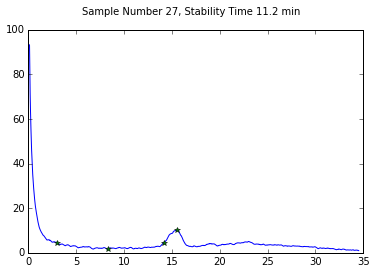

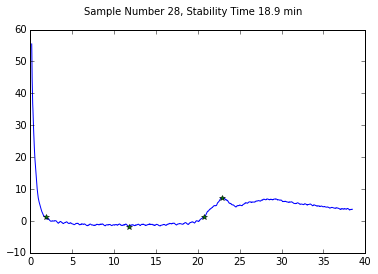

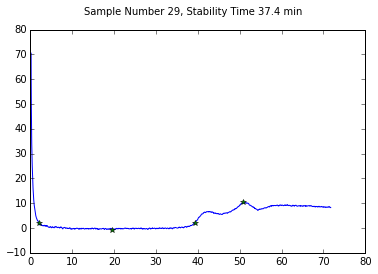

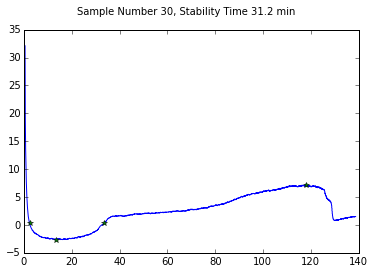

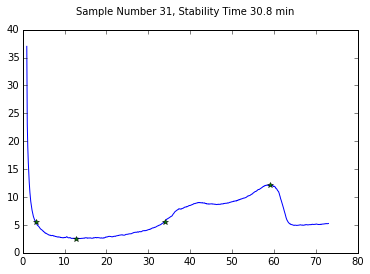

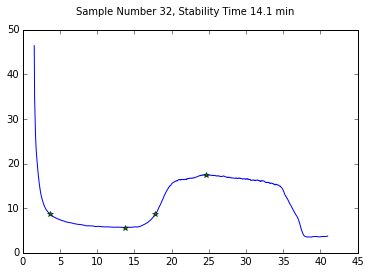

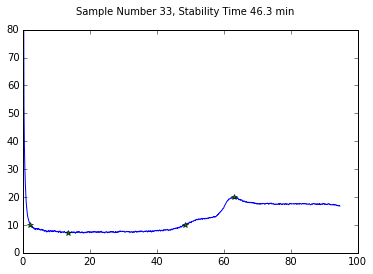

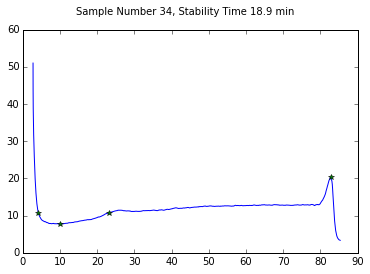

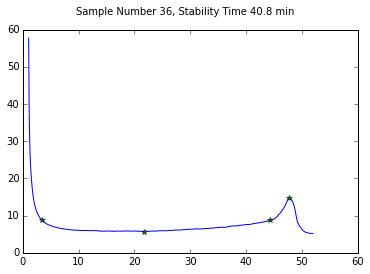

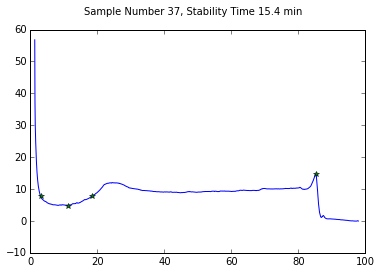

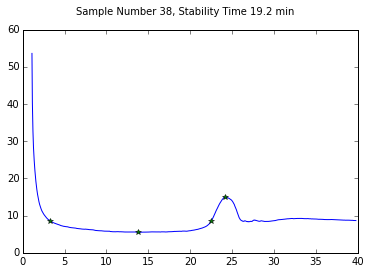

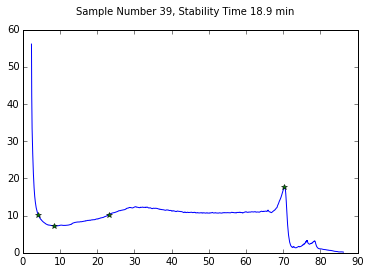

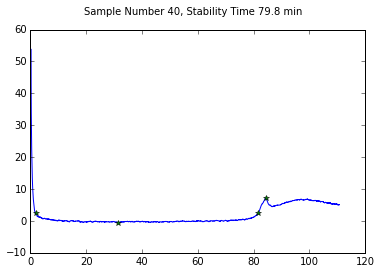

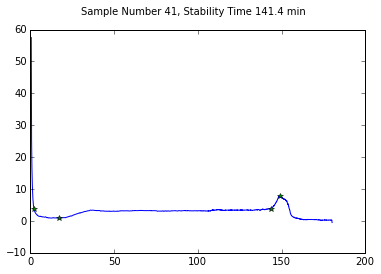

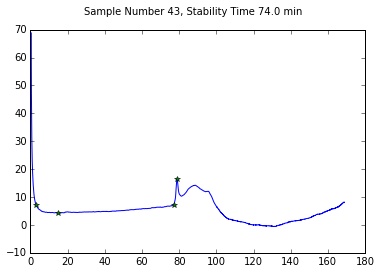

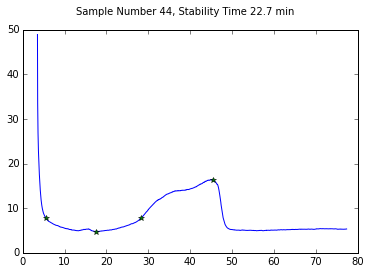

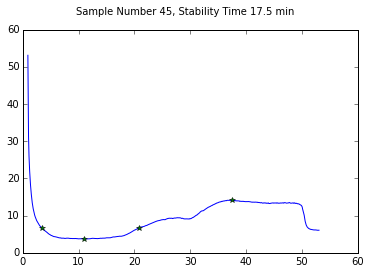

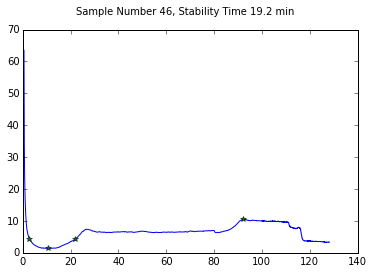

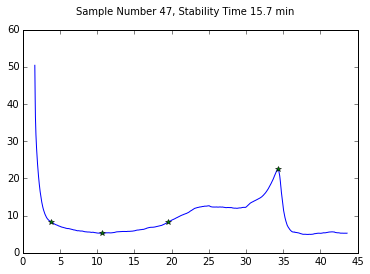

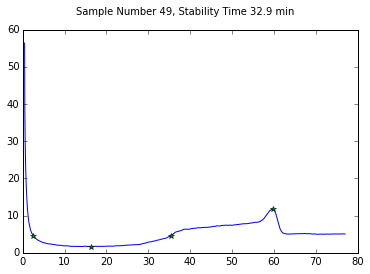

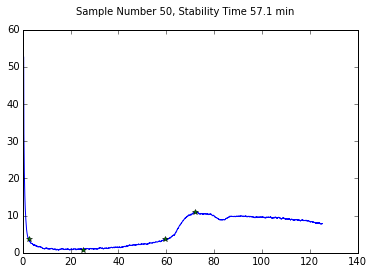

In [3]:
all_sample_numbers = []
all_stab_times = []
all_rest_torques = []
all_final_deg_times = []
all_diff_long_short = []

with PdfPages('Rheomix_Analysis.pdf') as pdf:
    for filename in Files:

        # parse filename to get sample number

        split_filename = filename.split('_')
        sample_number = split_filename[1][1:]

        data = pd.read_table(filename, skiprows = 3, sep=';')

        time_data = data['t [min]'].values
        torque_data = data['Torque [Nm]'].values

        # Remove NaN from data

        time_data = time_data[~isnan(time_data)]
        torque_data = torque_data[~isnan(torque_data)]

        # Find the first maximum of the curve
        # initial maximum for sample entering the rheomix 

        no_of_data_points = len(torque_data)

        # Divide data in to the first third and the second two thirds to captrue the two maximums

        cut_point = no_of_data_points/3
        torque_data_1 = torque_data[:cut_point]
        index_1 = argmax(torque_data_1)

        # Sample 4 needs special attention since it has a maximum before the initial maximum

        if sample_number == '04':
            extra = 1
            torque_data = torque_data[index_1 + extra:]
            time_data = time_data[index_1 + extra:]
            torque_data_1 = torque_data[:cut_point]
            index_1 = argmax(torque_data_1)

        # Cut data to exclude data points before first maximum

        time_data = time_data[index_1:]
        torque_data = torque_data[index_1:]
        
        # Filter Data using EWMA Filter 
        # 0 < alpha <= 1
        # alpha = 1 is no filtering, decrease alpha increase filtering
        
        alpha = 0.05
        my_com = 1.0/alpha - 1.0
        
        torque_data = pd.ewma(torque_data, com=my_com)

        # Find the second maximum of the curve
        # second maximum for final degradation point

        torque_data_2 = torque_data[cut_point:]

        index_2 = argmax(torque_data_2)
        index_2 = cut_point + index_2

        # Determine stability time

        index_min = argmin(torque_data[:index_2])
        torque_min = torque_data[index_min]
        
        # Threshold value set by user but is the same for every curve
        
        threshold = torque_min + 3.0

        i = 0
        t = torque_data[i]
        while t > threshold:
            i += 1
            t = torque_data[i]

        index_stab_start = i

        i = index_min
        t = torque_data[i]

        while t < threshold:
            i += 1
            t = torque_data[i]

        index_stab_end = i
        
        # Calculate stability time, resting torque, final degradation time
        
        stab_time = round(time_data[index_stab_end] - time_data[index_stab_start], 1)
        
        stab_torque = torque_data[index_stab_start:index_stab_end]
        rest_torque = round(mean(stab_torque), 1)
        
        final_deg_time = round(time_data[index_2] -  time_data[index_stab_start], 1)
        
        diff_long_short = round(final_deg_time - stab_time, 1)
        
        # Record all single values
        
        all_sample_numbers.append(int(sample_number))
        all_stab_times.append(stab_time)
        all_rest_torques.append(rest_torque)
        all_final_deg_times.append(final_deg_time)
        all_diff_long_short.append(diff_long_short)

        # plot results

        fig = figure()
        fig.suptitle('Sample Number ' + sample_number + ', Stability Time ' + str(stab_time) + ' min')
        plot(time_data, torque_data)

        all_indeces = [index_2, index_min, index_stab_start, index_stab_end]
        times = [time_data[i] for i in all_indeces]
        torques = [torque_data[i] for i in all_indeces]
        plot(times, torques, '*')

#         pdf.savefig(fig)

In [4]:
all_data = [all_sample_numbers, all_stab_times, all_final_deg_times, all_diff_long_short, all_rest_torques]
indeces = ['Sample Numbers', 'Stability Time (min)', 'Final Degredation Time (min)', 'Difference (min)', 'Stable Resting Torque (Nm)']

In [5]:
single_val_df = pd.DataFrame(data=all_data, index=indeces).transpose()

In [6]:
single_val_df

,Sample Numbers,Stability Time (min),Final Degredation Time (min),Difference (min),Stable Resting Torque (Nm)
0,1,56.1,80.0,23.9,1.3
1,3,128.2,235.4,107.2,3.7
2,4,24.0,85.0,61.0,8.5
3,5,37.1,150.5,113.4,1.2
4,6,23.7,26.5,2.8,7.8
5,7,54.2,56.2,2.0,4.2
6,8,57.9,73.5,15.6,5.0
7,9,31.3,34.1,2.8,3.2
8,10,8.5,20.2,11.7,3.1
9,11,19.1,74.5,55.4,7.6


In [7]:
single_val_df.to_csv('Rheomix_Single_Value_Analysis.csv')